# Task 2 - Analyse the given datasets about speed experiments and transform it into the structure required by the neural network

In the following we read in the bottleneck dataset, analyze its structure and calculate additional features as well as the velocity target.

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from helpers.data import SpeedExperimentDataset
from helpers.plots import simple_histogram, simple_scatter, create_walking_video, frame_evolution_plot, plot_trajectories

from IPython.display import Video

pd.set_option("display.max_columns", None)


### 1. Introduction to the data

The paper mentions two datasets of two different scenarios that were recorded in laboratory conditions and are [freely available on the internet](https://zenodo.org/record/1054017):
- corridor dataset: Trajectories of pedestrians in a closed corridor of lenght 30m and width 1.8m with N=15, 30, 60, 85, 95, 110, 140 and 230 participants.
- bottleneck: Trajectories of 150 pedestrians in a bottleneck of lenght 8m and width w=0.7, 0.95 1.2 and 1.8m.

Both data files can be found under `data/pedestrian_trajectories` and contain the same number of columns:
- `ID`: Unique identifier of each of the pedestrians
- `FRAME`: Frame number = relative timestep in the recording, frame rate of 16 fps
- `X`, `Y`, `Z`: pedestrian position in 3D in cm.

In the following, we are going to take a close look at the bottleneck dataset. In particular, we will analyze and transform the experiment with a width of 70 cm.

#### 1.1 Initializing a Speed Experiment Dataset class and taking a look at the available files

In [181]:
bottleneck_dataset = SpeedExperimentDataset(data_dir="bottleneck_data")
bottleneck_dataset.data_files


['data/pedestrian_trajectories/bottleneck_data/uo-180-070.txt',
 'data/pedestrian_trajectories/bottleneck_data/uo-180-095.txt',
 'data/pedestrian_trajectories/bottleneck_data/uo-180-120.txt',
 'data/pedestrian_trajectories/bottleneck_data/uo-180-180.txt']

#### 1.2 Loading the first file and inspecting it

#### 1.2.1 Load the data

Here we already converted the units of the positions `X`, `Y`, `Z` to meters.

In [182]:
bottleneck_dataset.read_data(only_n_files=1)
bottleneck_dataset.df


Loading 1 files ...


100%|██████████| 1/1 [00:00<00:00, 16.91it/s]

Making ID and FRAME unique across all files...
Fixing position units from cm to m...


,ID,FRAME,X,Y,Z,ORIGINAL_FILENAME
0,1_uo-180-070,218_uo-180-070,1.29748,7.87177,1.55467,uo-180-070
1,1_uo-180-070,219_uo-180-070,1.30771,7.72562,1.55467,uo-180-070
2,1_uo-180-070,220_uo-180-070,1.32569,7.58186,1.55467,uo-180-070
3,1_uo-180-070,221_uo-180-070,1.34659,7.45493,1.55467,uo-180-070
4,1_uo-180-070,222_uo-180-070,1.34878,7.34659,1.55467,uo-180-070
...,...,...,...,...,...,...
75331,148_uo-180-070,1581_uo-180-070,1.32408,-5.72917,1.63764,uo-180-070
75332,148_uo-180-070,1582_uo-180-070,1.33420,-5.82078,1.63764,uo-180-070
75333,148_uo-180-070,1583_uo-180-070,1.33959,-5.90682,1.63764,uo-180-070
75334,148_uo-180-070,1584_uo-180-070,1.34090,-5.98287,1.63764,uo-180-070


#### 1.2.2 Inspecting the structure of the data

There are 148 unique ids which is a bit surprising since the description of the dataset says that there are 150.

In [183]:
bottleneck_dataset.df["ID"].value_counts()


139_uo-180-070    776
133_uo-180-070    771
135_uo-180-070    767
113_uo-180-070    766
138_uo-180-070    756
                 ... 
5_uo-180-070      143
6_uo-180-070      142
1_uo-180-070      120
3_uo-180-070      116
2_uo-180-070      102
Name: ID, Length: 148, dtype: int64

There are 1600 frames which makes for 100 seconds of data.

In [184]:
bottleneck_dataset.df["FRAME"].value_counts().sort_values()


1817_uo-180-070     1
1812_uo-180-070     1
1811_uo-180-070     1
1816_uo-180-070     1
1815_uo-180-070     1
                   ..
759_uo-180-070     76
758_uo-180-070     76
757_uo-180-070     76
756_uo-180-070     76
765_uo-180-070     76
Name: FRAME, Length: 1600, dtype: int64

#### 1.2.3 Plotting the movement

##### 1.2.3.1 All pedestrians over time

At the very beginning, there are no congestions:

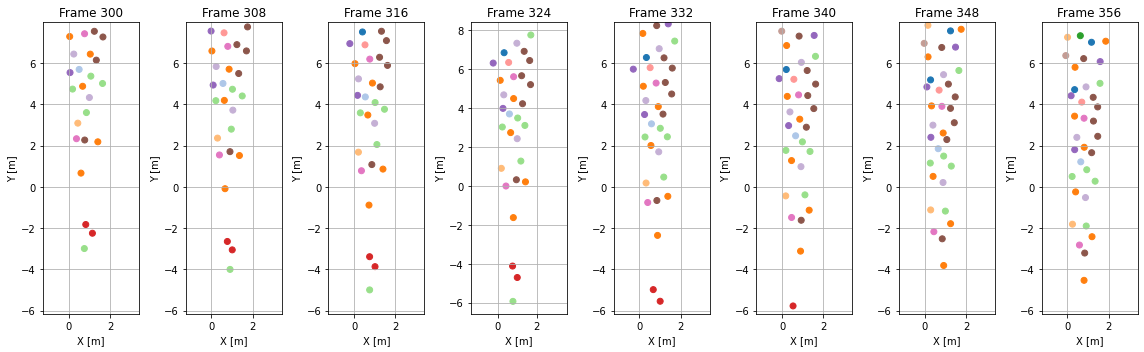

In [185]:
fig, ax = frame_evolution_plot(bottleneck_dataset.df, 300, 8, 8)
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_frame_evolution_300_356.pdf"), bbox_inches="tight")


However, after some time, the bottleneck at around $y=-4$ starts to slow the pedestrians down:

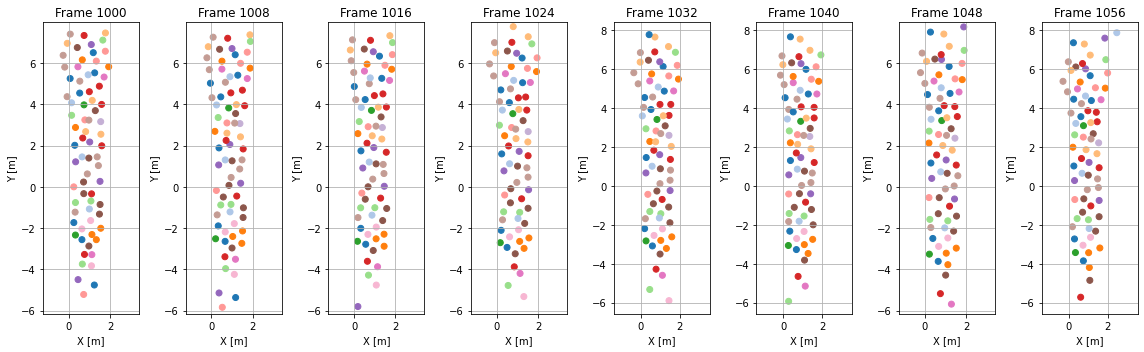

In [186]:
fig, ax = frame_evolution_plot(bottleneck_dataset.df, 1000, 8, 8)
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_frame_evolution_1000_1056.pdf"), bbox_inches="tight")


In [189]:
create_walking_video(df=bottleneck_dataset.df, filename=os.path.join("out", "walking_video.mp4"), first_n=500)


Creating images...


100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


Creating video frames...


100%|██████████| 500/500 [00:22<00:00, 22.40it/s]


Creating animation...


In [190]:
Video(os.path.join("out", "walking_video.mp4"))


##### 1.2.3.2 Show the trajectory of single pedestrians

The earliest pedestrians are still able to walk freely:

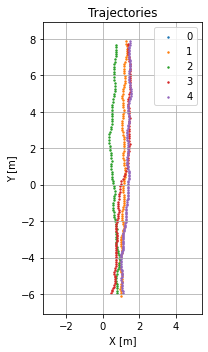

In [191]:
fig, ax = plot_trajectories(bottleneck_dataset.df, np.arange(0, 5, 1), title="Trajectories")
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_trajectories_0_4.pdf"), bbox_inches="tight")


While the congestion created by the bottleneck slows them down towards the end:

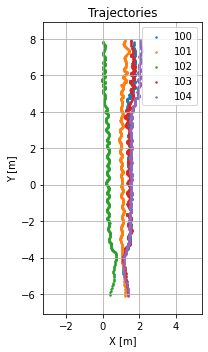

In [192]:
fig, ax = plot_trajectories(bottleneck_dataset.df, np.arange(100, 105, 1), title="Trajectories")
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_trajectories_100_104.pdf"), bbox_inches="tight")


#### 1.3 Transforming the data

In order to use the experiment data as described in the paper to predict velocity values, we need to perform two independent data transformation tasks:

- A) For each pedestrian at each frame: Estimate current velocity
- B) For each pedestrian at each frame: Find k=10 closest neighbors at that time, calculate distances and delta position to them.

##### 1.3 - A) Estimating velocity

In order to estimate the current velocity of each pedestrian at each frame, we are taking a look at previous X, Y, Z coordinates of the same pedestrian and then apply central differences to calculate the velocity.

In [6]:
bottleneck_dataset.calculate_velocity()
bottleneck_dataset.df


Calculating velocities...
Step 1/2: Adding previous and next position values...


100%|██████████| 148/148 [00:01<00:00, 141.80it/s]


Step 2/2: Calculating velocities...


100%|██████████| 75336/75336 [00:02<00:00, 28578.28it/s]


,ID,FRAME,X,Y,Z,ORIGINAL_FILENAME,VEL
0,1_uo-180-070,218_uo-180-070,1.29748,7.87177,1.55467,uo-180-070,2.344122
1,1_uo-180-070,219_uo-180-070,1.30771,7.72562,1.55467,uo-180-070,2.330234
2,1_uo-180-070,220_uo-180-070,1.32569,7.58186,1.55467,uo-180-070,2.187744
3,1_uo-180-070,221_uo-180-070,1.34659,7.45493,1.55467,uo-180-070,1.891203
4,1_uo-180-070,222_uo-180-070,1.34878,7.34659,1.55467,uo-180-070,1.701887
...,...,...,...,...,...,...,...
75331,148_uo-180-070,1581_uo-180-070,1.32408,-5.72917,1.63764,uo-180-070,1.457049
75332,148_uo-180-070,1582_uo-180-070,1.33420,-5.82078,1.63764,uo-180-070,1.426606
75333,148_uo-180-070,1583_uo-180-070,1.33959,-5.90682,1.63764,uo-180-070,1.297827
75334,148_uo-180-070,1584_uo-180-070,1.34090,-5.98287,1.63764,uo-180-070,1.145728


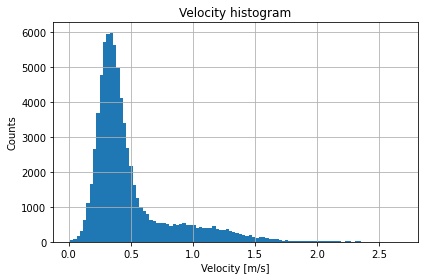

In [197]:
fig, ax = plt.subplots()
ax = simple_histogram(bottleneck_dataset.df["VEL"], "Velocity histogram", "Velocity [m/s]", num_bins=100, ax=ax)
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_velocity_histogram.pdf"), bbox_inches="tight")


##### 1.3 - B) Find k=10 closest neighbors and add delta information

This procedure adds the following columns to the data:
- `AVG_DISTANCE_TO_K_CLOSEST`: average disance to k closest other pedestrians during the same frame
- `ID_K`: ID of the k-th closest other pedestrian
- `DIST_K`: Delta distance of the k-th closest other pedestrian
- `DX_K`: Difference between x-position of current pedestrian and k-th closest one
- `DY_K`: Difference between y-position of current pedestrian and k-th closest one

In [24]:
bottleneck_dataset.append_with_k_nearest_neighbors(k=10)
bottleneck_dataset.df


,ID,FRAME,X,Y,Z,ORIGINAL_FILENAME,VEL,AVG_DISTANCE_TO_K_CLOSEST,ID_1,DIST_1,DX_1,DY_1,ID_2,DIST_2,DX_2,DY_2,ID_3,DIST_3,DX_3,DY_3,ID_4,DIST_4,DX_4,DY_4,ID_5,DIST_5,DX_5,DY_5,ID_6,DIST_6,DX_6,DY_6,ID_7,DIST_7,DX_7,DY_7,ID_8,DIST_8,DX_8,DY_8,ID_9,DIST_9,DX_9,DY_9,ID_10,DIST_10,DX_10,DY_10
0,1_uo-180-070,218_uo-180-070,129.748,787.177,155.467,uo-180-070,2.344122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1_uo-180-070,219_uo-180-070,130.771,772.562,155.467,uo-180-070,2.330234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1_uo-180-070,220_uo-180-070,132.569,758.186,155.467,uo-180-070,2.187744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1_uo-180-070,221_uo-180-070,134.659,745.493,155.467,uo-180-070,1.891203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1_uo-180-070,222_uo-180-070,134.878,734.659,155.467,uo-180-070,1.701887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75331,148_uo-180-070,1581_uo-180-070,132.408,-572.917,163.764,uo-180-070,1.457049,2.327220,125_uo-180-070,1.058844,0.470526,-0.94833,147_uo-180-070,1.558259,0.363799,-1.50950,129_uo-180-070,1.846218,0.629335,-1.73440,127_uo-180-070,2.087325,0.359985,-2.04917,130_uo-180-070,2.385082,0.753484,-2.26288,128_uo-180-070,2.535706,0.32158,-2.51489,133_uo-180-070,2.609630,-0.28442,-2.58854,132_uo-180-070,2.787248,0.535659,-2.73528,137_uo-180-070,3.140199,0.935602,-2.99754,131_uo-180-070,3.263689,0.375003,-3.24082
75332,148_uo-180-070,1582_uo-180-070,133.420,-582.078,163.764,uo-180-070,1.426606,2.396910,125_uo-180-070,1.097448,0.479824,-0.98678,147_uo-180-070,1.607582,0.373715,-1.55802,129_uo-180-070,1.923946,0.631085,-1.81631,127_uo-180-070,2.166578,0.391754,-2.12423,130_uo-180-070,2.457966,0.771726,-2.33362,128_uo-180-070,2.611169,0.33000,-2.58990,133_uo-180-070,2.688753,-0.27910,-2.66885,132_uo-180-070,2.863247,0.556572,-2.80862,137_uo-180-070,3.213128,0.946719,-3.07045,131_uo-180-070,3.339287,0.395147,-3.31460
75333,148_uo-180-070,1583_uo-180-070,133.959,-590.682,163.764,uo-180-070,1.297827,2.462401,125_uo-180-070,1.130007,0.486395,-1.01976,147_uo-180-070,1.655455,0.376028,-1.60683,129_uo-180-070,1.999107,0.628297,-1.89667,127_uo-180-070,2.240431,0.418410,-2.19459,130_uo-180-070,2.524456,0.784726,-2.39934,128_uo-180-070,2.678796,0.33359,-2.65762,133_uo-180-070,2.765496,-0.27722,-2.74634,132_uo-180-070,2.934625,0.572647,-2.87820,137_uo-180-070,3.282281,0.958275,-3.13924,131_uo-180-070,3.413359,0.411954,-3.38721
75334,148_uo-180-070,1584_uo-180-070,134.090,-598.287,163.764,uo-180-070,1.145728,2.519556,125_uo-180-070,1.159544,0.484042,-1.05348,147_uo-180-070,1.688179,0.371745,-1.64150,129_uo-180-070,2.069132,0.619444,-1.97314,127_uo-180-070,2.303003,0.434878,-2.25532,130_uo-180-070,2.584198,0.796918,-2.45820,128_uo-180-070,2.740867,0.32386,-2.72135,133_uo-180-070,2.837267,-0.27383,-2.81893,132_uo-180-070,2.994016,0.585742,-2.93615,137_uo-180-070,3.342879,0.966310,-3.20013,131_uo-180-070,3.476479,0.425531,-3.44916


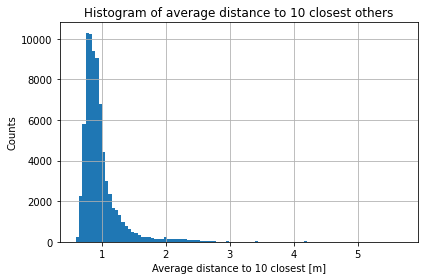

In [198]:
fig, ax = plt.subplots()
_ = simple_histogram(
    bottleneck_dataset.df["AVG_DISTANCE_TO_K_CLOSEST"],
    "Histogram of average distance to 10 closest others",
    "Average distance to 10 closest [m]",
    num_bins=100,
    ax=ax,
)
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_hist_avg_distance_to_10_closest.pdf"), bbox_inches="tight")


##### 1.3 C) - Chaining transformation steps
Since the transformation methods all return the same object instance again, we can compactly perform all the transformations at once:

In [ ]:
bottleneck_dataset.calculate_velocity().append_with_k_nearest_neighbors()


### 1.4 Inspecting relation between the features and the target

#### 1.4.1 Average distance vs. velocity

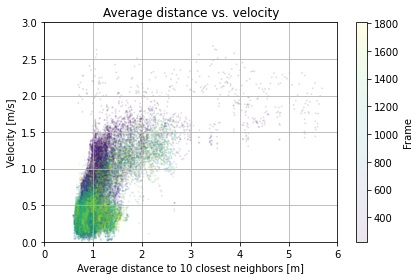

In [9]:
fig, ax = plt.subplots()
ax = simple_scatter(
    bottleneck_dataset.df["AVG_DISTANCE_TO_K_CLOSEST"],
    bottleneck_dataset.df["VEL"],
    title="Average distance vs. velocity",
    xlabel="Average distance to 10 closest neighbors [m]",
    ylabel="Velocity [m/s]",
    xlim=[0, 6],
    alpha=0.1,
    s=1,
    axis_equal=False,
    ax=ax,
    c=bottleneck_dataset.df["FRAME"].apply(lambda x: x.split("_")[0]).astype(int),
)
ax.set_ylim(0, 3)
cbar = fig.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Frame")
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_scatter_avg_distance_vs_velocity.png"), bbox_inches="tight", dpi=600)


#### 1.4.2 Distance to closest neighbor vs. velocity

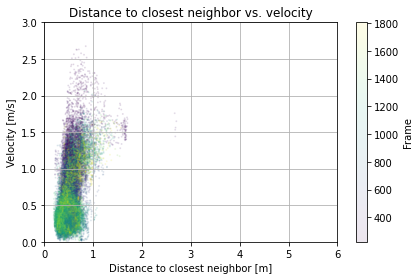

In [12]:
fig, ax = plt.subplots()
ax = simple_scatter(
    bottleneck_dataset.df["DIST_1"],
    bottleneck_dataset.df["VEL"],
    title="Distance to closest neighbor vs. velocity",
    xlabel="Distance to closest neighbor [m]",
    ylabel="Velocity [m/s]",
    xlim=[0, 6],
    alpha=0.1,
    axis_equal=False,
    s=1,
    ax=ax,
    c=bottleneck_dataset.df["FRAME"].apply(lambda x: x.split("_")[0]).astype(int),
)
ax.set_ylim(0, 3)
cbar = fig.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Frame")
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_scatter_neighb_1_vs_velocity.png"), bbox_inches="tight", dpi=600)


#### 1.4.3 Distance to 10th closes neighbor vs. velocity

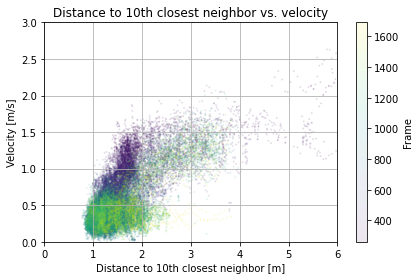

In [13]:
fig, ax = plt.subplots()
ax = simple_scatter(
    bottleneck_dataset.df["DIST_10"],
    bottleneck_dataset.df["VEL"],
    title="Distance to 10th closest neighbor vs. velocity",
    xlabel="Distance to 10th closest neighbor [m]",
    ylabel="Velocity [m/s]",
    xlim=[0, 6],
    alpha=0.1,
    axis_equal=False,
    s=1,
    ax=ax,
    c=bottleneck_dataset.df["FRAME"].apply(lambda x: x.split("_")[0]).astype(int),
)
ax.set_ylim(0, 3)
cbar = fig.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Frame")
fig.tight_layout()
fig.savefig(os.path.join("out", "task_2_scatter_neighb_10_vs_velocity.png"), bbox_inches="tight", dpi=600)


### 1.4 - Saving and loading

Since adding the delta information about the k=10 closest pedestrians at each timestep is computationally expensive, the `SpeedExperimentDataset` class provides several saving and loading utilities:

- `SpeedExperimentDataset().save(save_dir, filename)`: Serializes the python object and saves it.
- `SpeedExperimentDataset.load(save_dir, filename)`: Loads the serialized python object and returns the object instance.
- `SpeedExperimentDataset().save_data(save_dir, filename)`: Exports the dataframe attribute as a `.csv` file.

#### 1.4.1 - Serialize the full object

In [31]:
bottleneck_dataset.save(save_dir=os.path.join("data", "modified"), filename="bottleneck_070")


#### 1.4.2 - Load Serialized object

In [3]:
bottleneck_dataset = SpeedExperimentDataset.load(save_dir=os.path.join("data", "modified"), filename="bottleneck_070")


#### 1.4.3 - Export dataframe as .csv

In [3]:
bottleneck_dataset.save_data(save_dir=os.path.join("data", "modified"), filename="bottleneck_070")


### 1.5 Transformation + Saving as a chain of methods

Since the transformation takes a lot of time, it is very convenient to directly safe it once it is finished.

In [ ]:
bottleneck_dataset.read_data(only_n_files=1).calculate_velocity().append_with_k_nearest_neighbors(k=10).save(
    save_dir=os.path.join("data", "modified"), filename="bottleneck_070"
)
